In [1]:
import os
#nomber del modelo, es usado como id 
model_name =  "chatbot_testv1.0"
data_name = "Agente-5.csv"
text_sep = ";"
if not(os.path.isdir(model_name)):
    try:
        os.mkdir(model_name)
    except OSError:
        print ("Error creando carpeta" % model_name)
    else:
        print ("Carpeta creada correctamente %s " % model_name)
    
#Definir Hiperparametros
max_num_words = 4000
percentil = 98 #100 - percentil seria el porcentaje de las colas en una disbrucion normal a no ser tomado en cuenta, introducimos variabilidad al test de entrenamiento
test_size = 0.2
use_global_vector= False
vec_dim = 300 #dimension de los vectores en base a los vectores pre entrenados si usamos embedding


In [2]:
#leer datos
import numpy as np
import pandas as pd
my_data = pd.read_csv('data/'+data_name, sep=text_sep, header=None)
my_data
text = np.array(my_data[1]) #texto asociado a la intencion
labels = np.array(my_data[0]) #intencion

In [3]:
#limpiado datos signos de puntuacion, todo a miniscula y quitar las tildes
import string
import re
def cleanText(textToClean):
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in textToClean]
    return stripped

def toLowerCase(textToClean):
    textToClean = [word.lower() for word in textToClean]
    return textToClean
    
def remove_accents_wrapper(textToClean):
    textToClean = re.sub(u"[àáâãäå]", 'a', textToClean)
    textToClean = re.sub(u"[èéêë]", 'e', textToClean)
    textToClean = re.sub(u"[ìíîï]", 'i', textToClean)
    textToClean = re.sub(u"[òóôõö]", 'o', textToClean)
    textToClean = re.sub(u"[ùúûü]", 'u', textToClean)
    textToClean = re.sub(u"[ñ]", 'n', textToClean)
    return textToClean

def remove_accents(textToClean):
    textToClean = [remove_accents_wrapper(word) for word in textToClean]
    return textToClean


text = remove_accents(toLowerCase(cleanText(text)))


In [4]:
#generar test de prueba 
from sklearn.model_selection import train_test_split
train_txt,test_txt,train_label,test_labels = train_test_split(text,labels,test_size = test_size)
print("texto para entrenar y el label", train_txt, train_label)
print("texto para validar y el label", test_txt, test_labels)

texto para entrenar y el label ['costo de los cursos', 'de que va el curso', 'requisitos previos de ingreso  al curso', 'cual es la duracion de psicologia social', 'que docente imparte el mooc', 'cuales son los prerequisitos', 'cual es el profe de salud sexual y reproductiva', 'requisitos previos', 'cuanto cuesta el mooc de administracion empresarial', 'cual es el valor de los componentes', 'cuentame que cursos tienes', 'muestrame un resumen del mooc', 'cuales son los requisitos necesarios para el curso de emprendimiento', 'cual es precio del curso', 'contenido del curso', 'me puedes indicar los prerequistos necesarios', 'precio', 'valor del curso', 'que deberia saber para tomar el curso', 'numero de horas del mooc', 'conocimientos previos', 'quien es el docente encargado de la materia', 'cual es la tematica de cada curso', 'cuanto dura el curso de empendimiento', 'que tengo que saber', 'que cursos tiene', 'cuales son los contenidos a tratar en el curos de emprendimiento', 'de cuantas 

In [5]:
#tokenizar y aplicar padding
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
classes = np.unique(labels)

#tokenizamos
tokenizer = Tokenizer(num_words=max_num_words)
tokenizer.fit_on_texts(train_txt)
word_index = tokenizer.word_index #obtenemos el diccionario

# añadimos padding
ls=[]
for c in train_txt:
    ls.append(len(c.split()))
maxLen=int(np.percentile(ls, percentil))
train_sequences = tokenizer.texts_to_sequences(train_txt)
train_sequences = pad_sequences(train_sequences, maxlen=maxLen,padding='post')
test_sequences = tokenizer.texts_to_sequences(test_txt)
test_sequences = pad_sequences(test_sequences, maxlen=maxLen, padding='post')
train_sequences,test_sequences

(array([[ 55,   3,   5,  10,   0,   0,   0,   0,   0],
        [  3,   4,  20,   1,   2,   0,   0,   0,   0],
        [ 21,  22,   3,  56,  37,   2,   0,   0,   0],
        [ 11,   6,  29,  57,   3,  58,  59,   0,   0],
        [  4,  13,  60,   1,   7,   0,   0,   0,   0],
        [ 17,  18,   5,  38,   0,   0,   0,   0,   0],
        [ 11,   6,   1,  61,   3,  62,  63,  64,  65],
        [ 21,  22,   0,   0,   0,   0,   0,   0,   0],
        [  9,  23,   1,   7,   3,  66,  67,   0,   0],
        [ 11,   6,   1,  30,   3,   5,  68,   0,   0],
        [ 69,   4,  10,  70,   0,   0,   0,   0,   0],
        [ 39,  24,  71,   8,   7,   0,   0,   0,   0],
        [ 18,   5,  21,  40,  25,   1,   2,   3,  14],
        [ 11,   6,  26,   8,   2,   0,   0,   0,   0],
        [ 72,   8,   2,   0,   0,   0,   0,   0,   0],
        [ 41,  73,  74,   5,  75,  40,   0,   0,   0],
        [ 26,   0,   0,   0,   0,   0,   0,   0,   0],
        [ 30,   8,   2,   0,   0,   0,   0,   0,   0],
        [ 

In [6]:
#guardamos el tokenizador como json
import json
with open(model_name+'/tokenizer.json', 'w') as outfile:
    json.dump(word_index, outfile)

In [7]:
#aplicamos One-Hot Encoding
from sklearn.preprocessing import OneHotEncoder,LabelEncoder

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(classes)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoder.fit(integer_encoded)

train_label_encoded = label_encoder.transform(train_label)
train_label_encoded = train_label_encoded.reshape(len(train_label_encoded), 1)
train_label = onehot_encoder.transform(train_label_encoded)

test_labels_encoded = label_encoder.transform(test_labels)
test_labels_encoded = test_labels_encoded.reshape(len(test_labels_encoded), 1)
test_labels = onehot_encoder.transform(test_labels_encoded)

train_label,test_labels

(array([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0

In [8]:

print("cargando vectores")
embeddings_index={}
with open('glove-spanish.txt', encoding='utf8') as f:
    i = 0
    longitud = 300
    for line in f:
        if (i>0):
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
            if (len(coefs) != longitud):
                print('Error', word, len(coefs))
        i = i + 1

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
num_words = min(max_num_words, len(word_index))+1
embedding_dim=len(embeddings_index['de'])
embedding_matrix = np.random.normal(emb_mean, emb_std, (num_words, embedding_dim))
for word, i in word_index.items():
    if i >= max_num_words:
        break
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
embedding_matrix

cargando vectores


C:\Users\hug0er\Anaconda3\envs\intent_classification\lib\site-packages\IPython\core\interactiveshell.py:3357: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


array([[ 0.01434523,  0.03777922,  0.06077202, ..., -0.08036641,
        -0.02992102,  0.06932615],
       [-0.019094  , -0.054838  ,  0.061867  , ..., -0.13208701,
        -0.024071  ,  0.061029  ],
       [-0.008963  , -0.04008   ,  0.045394  , ..., -0.086183  ,
        -0.041549  , -0.059552  ],
       ...,
       [-0.064706  , -0.007148  , -0.026217  , ...,  0.024468  ,
        -0.008087  ,  0.020211  ],
       [ 0.065402  ,  0.045958  ,  0.003894  , ..., -0.029495  ,
        -0.077731  ,  0.004105  ],
       [-0.047156  , -0.041935  , -0.037637  , ..., -0.13139901,
        -0.014932  , -0.034406  ]])

In [30]:
#modelo de aprendizaje
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Input, Dropout, LSTM, Activation, Bidirectional,Embedding

model = Sequential()
model.add(Embedding(num_words, vec_dim, trainable=False,input_length=train_sequences.shape[1], weights=[embedding_matrix]))
model.add(Bidirectional(LSTM(256, return_sequences=True, recurrent_dropout=0.1, dropout=0.1), 'concat'))
model.add(Dropout(0.3))
model.add(LSTM(256, return_sequences=False, recurrent_dropout=0.1, dropout=0.1))
model.add(Dropout(0.3))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(classes.shape[0], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [31]:
history = model.fit(train_sequences, train_label, epochs = 150,
          batch_size = 10, shuffle=True,
          validation_data=(test_sequences, test_labels))


Epoch 1/150
8/8 [==============================] - 2s 249ms/step - loss: 2.1195 - acc: 0.1974 - val_loss: 2.5752 - val_acc: 0.1000
Epoch 2/150
8/8 [==============================] - 1s 104ms/step - loss: 2.0353 - acc: 0.2237 - val_loss: 2.5172 - val_acc: 0.0000e+00
Epoch 3/150
8/8 [==============================] - 1s 105ms/step - loss: 2.0780 - acc: 0.2368 - val_loss: 2.2984 - val_acc: 0.2000
Epoch 4/150
8/8 [==============================] - 1s 103ms/step - loss: 2.0872 - acc: 0.2105 - val_loss: 2.3350 - val_acc: 0.1500
Epoch 5/150
8/8 [==============================] - 1s 104ms/step - loss: 1.8943 - acc: 0.2895 - val_loss: 2.1493 - val_acc: 0.2500
Epoch 6/150
8/8 [==============================] - 1s 102ms/step - loss: 1.7942 - acc: 0.3421 - val_loss: 2.0206 - val_acc: 0.2000
Epoch 7/150
8/8 [==============================] - 1s 104ms/step - loss: 1.5867 - acc: 0.4605 - val_loss: 1.7573 - val_acc: 0.4000
Epoch 8/150
8/8 [==============================] - 1s 103ms/step - loss: 1.2815

8/8 [==============================] - 1s 102ms/step - loss: 0.0090 - acc: 1.0000 - val_loss: 2.7545 - val_acc: 0.5500
Epoch 64/150
8/8 [==============================] - 1s 102ms/step - loss: 0.0065 - acc: 1.0000 - val_loss: 2.7919 - val_acc: 0.5500
Epoch 65/150
8/8 [==============================] - 1s 101ms/step - loss: 0.0094 - acc: 1.0000 - val_loss: 2.8169 - val_acc: 0.5500
Epoch 66/150
8/8 [==============================] - 1s 102ms/step - loss: 0.0095 - acc: 1.0000 - val_loss: 2.8585 - val_acc: 0.5500
Epoch 67/150
8/8 [==============================] - 1s 101ms/step - loss: 0.0044 - acc: 1.0000 - val_loss: 2.8780 - val_acc: 0.5500
Epoch 68/150
8/8 [==============================] - 1s 102ms/step - loss: 0.0054 - acc: 1.0000 - val_loss: 2.9087 - val_acc: 0.5500
Epoch 69/150
8/8 [==============================] - 1s 103ms/step - loss: 0.0070 - acc: 1.0000 - val_loss: 2.9577 - val_acc: 0.5500
Epoch 70/150
8/8 [==============================] - 1s 103ms/step - loss: 0.0153 - acc: 1

Epoch 125/150
8/8 [==============================] - 1s 100ms/step - loss: 7.7225e-04 - acc: 1.0000 - val_loss: 3.5394 - val_acc: 0.5500
Epoch 126/150
8/8 [==============================] - 1s 103ms/step - loss: 9.4316e-04 - acc: 1.0000 - val_loss: 3.5493 - val_acc: 0.5500
Epoch 127/150
8/8 [==============================] - 1s 103ms/step - loss: 0.0011 - acc: 1.0000 - val_loss: 3.5522 - val_acc: 0.5500
Epoch 128/150
8/8 [==============================] - 1s 101ms/step - loss: 0.0013 - acc: 1.0000 - val_loss: 3.5531 - val_acc: 0.5500
Epoch 129/150
8/8 [==============================] - 1s 104ms/step - loss: 0.0025 - acc: 1.0000 - val_loss: 3.5594 - val_acc: 0.5500
Epoch 130/150
8/8 [==============================] - 1s 102ms/step - loss: 6.8396e-04 - acc: 1.0000 - val_loss: 3.5516 - val_acc: 0.5500
Epoch 131/150
8/8 [==============================] - 1s 103ms/step - loss: 0.0024 - acc: 1.0000 - val_loss: 3.5541 - val_acc: 0.5500
Epoch 132/150
8/8 [==============================] - 1s 1

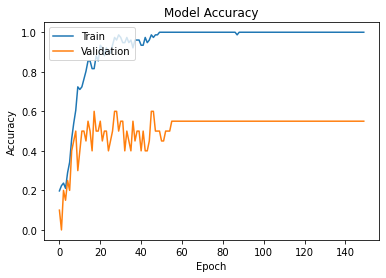

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

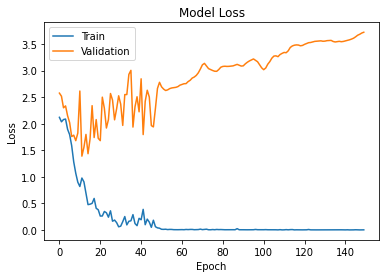

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [13]:
#guardamos el modelo
import pickle
import json
model.save(model_name+'/intents.h5')

with open(model_name+'/classes.pkl','wb') as file:
   pickle.dump(classes,file)

with open(model_name+'/tokenizer.pkl','wb') as file:
   pickle.dump(tokenizer,file)

with open(model_name+'/label_encoder.pkl','wb') as file:
   pickle.dump(label_encoder,file)

In [14]:
import pickle
from tensorflow.python.keras.models import load_model


with open(model_name+'/classes.pkl','rb') as file:
  classes = pickle.load(file)

with open(model_name+'/tokenizer.pkl','rb') as file:
  tokenizer = pickle.load(file)

with open(model_name+'/label_encoder.pkl','rb') as file:
  label_encoder = pickle.load(file)

model = load_model(model_name+'/intents.h5')

In [15]:
import numpy as np
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
class IntentClassifier:
    def __init__(self,classes,model,tokenizer,label_encoder):
        self.classes = classes
        self.classifier = model
        self.tokenizer = tokenizer
        self.label_encoder = label_encoder

    def get_intent(self,text):
        self.text = text
        self.test_keras = self.tokenizer.texts_to_sequences(self.text)
        self.test_keras_sequence = pad_sequences(self.test_keras, maxlen=maxLen, padding='post')
        print(self.test_keras_sequence)
        self.pred = self.classifier.predict(self.test_keras_sequence)
        print(self.pred,np.argmax(self.pred,1))
        return self.label_encoder.inverse_transform(np.argmax(self.pred,1))[0]

In [16]:
#guardamos el decodificador haciendo ingenieria inversa de la red 
data = {}
j= 0
for i in label_encoder.inverse_transform([i for i in range(0,maxLen)]):
    data[j] = i
    j += 1
    
with open(model_name+'label_encoder.json', 'w') as outfile:
    json.dump(data, outfile)

In [17]:
#probamos el modelo

oracion = "Díme el listado de los cursos?"
nlu = IntentClassifier(classes,model,tokenizer,label_encoder)
textToProof = remove_accents(toLowerCase(cleanText([oracion])))
print(textToProof)
print(nlu.get_intent(textToProof))


['dime el listado de los cursos']
[[ 1  3  5 10  0  0  0  0  0]]
[[3.2284714e-03 7.0030882e-04 2.2170607e-05 2.1949394e-03 4.7864038e-01
  3.3371575e-04 4.9496952e-01 1.9343637e-02 5.6688383e-04]] [6]
qCBvJo4cn9VmTOrsbyC8
